In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix)
import seaborn as sns
import pandas as pd
from torch.utils.data import SubsetRandomSampler, DataLoader
import time
import torch.nn.functional as F
import optuna  # For hyperparameter tuning
import random

In [ ]:
# Setting Seed for reprducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# Using GPU
device = torch.device('cuda')

In [ ]:
# Training parmeters for my exeriment
num_epchs = 15 
batch_size = 128
valid_size = 0.1 

In [ ]:
# Mean and Standard deviation of the Cifar 10 Dataset.
# This will be used for normalisation process
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

In [ ]:
# Doing data augmentation and normalization process for training
transform_train_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
# No Augmentation for No Augmentation model
transform_train_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [ ]:
# Training and Val Split
def get_train_valid_indices(train_dataset):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.seed(42)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    return train_idx, valid_idx

In [ ]:
# getting loader for training, val and test
def get_data_loaders(transform_train, train_idx, valid_idx):
    train_ds = torchvision.datasets.CIFAR10(root='./data',
                                            train=True,
                                            download=True,
                                            transform=transform_train)

    test_ds = torchvision.datasets.CIFAR10(root='./data',
                                           train=False,
                                           download=True,
                                           transform=transform_test)
    # Subset samplers for training and val
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    # Create Data-Loader
    train_ldr = DataLoader(train_ds,
                              batch_size=batch_size,
                              sampler=train_sampler,
                              num_workers=2)

    valid_ldr = DataLoader(train_ds,
                              batch_size=batch_size,
                              sampler=valid_sampler,
                              num_workers=2)

    test_ldr = DataLoader(test_ds,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=2)
    return train_ldr, valid_ldr, test_ldr

In [ ]:
# Accuracy and top-k accuracy 
def accuracy(output, target, topk=(1,)):
    """Computes the number of correct predictions over the k top predictions"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t() 
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k)
    return res

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Custom CNN Architecture
class CIFAR10ModifiedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10ModifiedCNN, self).__init__()
        # First Conv Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) # Batch normalisation
        self.pool1 = nn.MaxPool2d(2, 2) # Max pooling operation
        self.dropout1 = nn.Dropout(0.3) # Dropout (30% of neurons), preventing overfitting

        # Second Conv Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)

        #Third Conv Block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.3)
        
        # Full connected block
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)

        # Skip connection via residual connection
        self.residual = nn.Conv2d(32, 128, kernel_size=1, stride=4, padding=0)
    
    # The Mish Activation Function :)
    def mish(self, x):
        return x * torch.tanh(F.softplus(x))
    
    # Forward pass
    def forward(self, x):
        x = self.mish(self.bn1(self.conv1(x)))
        x = self.mish(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Residual connection input
        identity = self.residual(x)

        # Second block
        x = self.mish(self.bn3(self.conv3(x)))
        x = self.mish(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # third lock
        x = self.mish(self.bn5(self.conv5(x)))
        x = self.mish(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # adding residual connection
        x += identity

        # flattening feature maps so that it can pass through fully connction layer
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layer
        x = self.mish(self.bn_fc1(self.fc1(x)))
        x = self.mish(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [ ]:
# Obj. Function for hyperparmeter tuning using Optuna Framework
def objective(trial, transform_train, train_idx, valid_idx):
    # Search Space
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.5, 0.99)
    else:
        momentum = None 
    # Getting data loader
    train_ldr, valid_ldr, _ = get_data_loaders(transform_train, train_idx, valid_idx)
    # Model Architecture
    model = CIFAR10ModifiedCNN(num_classes=10)

    model = model.to(device)

    torch.manual_seed(42)
    # Loss Function
    criterion = nn.CrossEntropyLoss()
    # Setting Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # Learning rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # Training loop
    for epoch in range(num_epchs):
        model.train()
        for images, labels in train_ldr:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_ldr:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
        # accuracy calc
        valid_acc = 100 * correct_valid / total_valid

        trial.report(valid_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        # stepping scheduler
        scheduler.step()

    return valid_acc

In [ ]:
# Function for running hyper - parmeter tuning
def run_hyperparameter_tuning(transform_train, experiment_name, train_idx, valid_idx):
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, transform_train, train_idx, valid_idx), n_trials=10)

    print(f"\nBest hyperparameters for {experiment_name}:")
    print(study.best_trial.params)
    print(f"Best validation accuracy: {study.best_value:.2f}%")

    return study.best_trial.params
# Dataset for traing,val split
train_dataset_for_indices = torchvision.datasets.CIFAR10(root='./data',
                                                         train=True,
                                                         download=True,
                                                         transform=transform_train_no_aug)
train_idx_global, valid_idx_global = get_train_valid_indices(train_dataset_for_indices)

Files already downloaded and verified


In [ ]:
print("Running hyperparameter tuning with data augmentation...")
best_params_aug = run_hyperparameter_tuning(transform_train_augmented, "With_Data_Augmentation", train_idx_global, valid_idx_global)

[I 2024-11-09 04:57:06,057] A new study created in memory with name: no-name-f450f17a-02c4-4954-9037-c2416eb4f3f4


Running hyperparameter tuning with data augmentation...
Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:02:52,116] Trial 0 finished with value: 80.44 and parameters: {'optimizer': 'SGD', 'lr': 0.015702970884055395, 'weight_decay': 0.0006251373574521745, 'momentum': 0.5764491338167939}. Best is trial 0 with value: 80.44.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:07:58,799] Trial 1 finished with value: 59.96 and parameters: {'optimizer': 'Adam', 'lr': 0.0396760507705299, 'weight_decay': 0.0006358358856676254}. Best is trial 0 with value: 80.44.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:13:03,337] Trial 2 finished with value: 40.72 and parameters: {'optimizer': 'Adam', 'lr': 0.0812324508558869, 'weight_decay': 0.00314288089084011}. Best is trial 0 with value: 80.44.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:18:12,191] Trial 3 finished with value: 83.58 and parameters: {'optimizer': 'Adam', 'lr': 0.0003549878832196505, 'weight_decay': 8.17949947521167e-05}. Best is trial 3 with value: 83.58.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:23:22,117] Trial 4 finished with value: 85.28 and parameters: {'optimizer': 'Adam', 'lr': 0.0007476312062252305, 'weight_decay': 0.000684792009557478}. Best is trial 4 with value: 85.28.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:23:44,733] Trial 5 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:24:08,370] Trial 6 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:24:31,704] Trial 7 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:24:54,707] Trial 8 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:30:11,593] Trial 9 finished with value: 86.32 and parameters: {'optimizer': 'Adam', 'lr': 0.0030586566669785274, 'weight_decay': 1.2681352169084594e-05}. Best is trial 9 with value: 86.32.



Best hyperparameters for With_Data_Augmentation:
{'optimizer': 'Adam', 'lr': 0.0030586566669785274, 'weight_decay': 1.2681352169084594e-05}
Best validation accuracy: 86.32%


In [ ]:
print("\nRunning hyperparameter tuning without data augmentation...")
best_params_no_aug = run_hyperparameter_tuning(transform_train_no_aug, "Without_Data_Augmentation", train_idx_global, valid_idx_global)

[I 2024-11-09 05:30:11,622] A new study created in memory with name: no-name-236f2823-8f5a-4701-9d52-6c3f963e25a5



Running hyperparameter tuning without data augmentation...
Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:35:11,532] Trial 0 finished with value: 83.9 and parameters: {'optimizer': 'SGD', 'lr': 0.015702970884055395, 'weight_decay': 0.0006251373574521745, 'momentum': 0.5764491338167939}. Best is trial 0 with value: 83.9.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:42:15,363] Trial 1 finished with value: 66.5 and parameters: {'optimizer': 'Adam', 'lr': 0.0396760507705299, 'weight_decay': 0.0006358358856676254}. Best is trial 0 with value: 83.9.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:49:31,740] Trial 2 finished with value: 45.84 and parameters: {'optimizer': 'Adam', 'lr': 0.0812324508558869, 'weight_decay': 0.00314288089084011}. Best is trial 0 with value: 83.9.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 05:56:51,405] Trial 3 finished with value: 85.3 and parameters: {'optimizer': 'Adam', 'lr': 0.0003549878832196505, 'weight_decay': 8.17949947521167e-05}. Best is trial 3 with value: 85.3.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 06:02:25,675] Trial 4 finished with value: 87.04 and parameters: {'optimizer': 'Adam', 'lr': 0.0007476312062252305, 'weight_decay': 0.000684792009557478}. Best is trial 4 with value: 87.04.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 06:02:49,918] Trial 5 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 06:03:15,025] Trial 6 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 06:03:40,037] Trial 7 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 06:04:03,808] Trial 8 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 06:09:13,464] Trial 9 finished with value: 86.78 and parameters: {'optimizer': 'Adam', 'lr': 0.0030586566669785274, 'weight_decay': 1.2681352169084594e-05}. Best is trial 4 with value: 87.04.



Best hyperparameters for Without_Data_Augmentation:
{'optimizer': 'Adam', 'lr': 0.0007476312062252305, 'weight_decay': 0.000684792009557478}
Best validation accuracy: 87.04%


In [ ]:
# Training and evaluating the model on best parameter we've got
def train_and_evaluate(best_params, transform_train, experiment_name, train_idx, valid_idx):
    train_ldr, valid_ldr, test_ldr = get_data_loaders(transform_train, train_idx, valid_idx)
    model = CIFAR10ModifiedCNN(num_classes=10)
    model = model.to(device)
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer_name = best_params['optimizer']
    lr = best_params['lr']
    weight_decay = best_params['weight_decay']
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        momentum = best_params['momentum']
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # Stroring results in these variables
    trainLosses = []
    validLosses = []
    train_accu = []
    valid_accu = []
    best_valid_acc = 0.0
    best_model_state = None 
    # Training loop
    total_training_time = 0.0
    for epoch in range(num_epchs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_ldr:
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # backward pass and optimizer step.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # trainng metrics calculation
        epoch_loss = running_loss / len(train_ldr.sampler)
        epoch_acc = 100 * correct / total
        trainLosses.append(epoch_loss)
        train_accu.append(epoch_acc)
        # val loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_ldr:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(valid_ldr.sampler)
        valid_acc = 100 * correct_valid / total_valid
        validLosses.append(valid_loss)
        valid_accu.append(valid_acc)
        # calculating duration of epoch
        epoch_duration = time.time() - epoch_start_time
        total_training_time += epoch_duration

        print(f'[{experiment_name}] Epoch [{epoch+1}/{num_epchs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, '
              f'Time: {epoch_duration:.2f}s')
        # saving best model
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, f'best_model_{experiment_name}.pth')
            print(f'[{experiment_name}] Best model saved at epoch {epoch+1} with validation accuracy: {best_valid_acc:.2f}%')

        scheduler.step()
    # load best model for evaluation
    model.load_state_dict(best_model_state)
    model.eval()
    # test loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []
    # top k accuracy tracking
    top1_correct = 0
    top3_correct = 0 

    inference_start_time = time.time()

    with torch.no_grad():
        for images, labels in test_ldr:
            images = images.to(device)
            labels = labels.to(device)

            batch_size = images.size(0)
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * batch_size
            # top 1 and 3 acc.
            correct1, correct3 = accuracy(outputs, labels, topk=(1, 3))
            top1_correct += correct1.item()
            top3_correct += correct3.item()

            total_test += batch_size
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # calculating inference time
    inference_duration = time.time() - inference_start_time
    average_inference_time = inference_duration / total_test
    # calculating testing metrics
    test_loss = test_loss / len(test_ldr.dataset)
    top1_acc = 100 * top1_correct / total_test
    top3_acc = 100 * top3_correct / total_test 
    # results
    print(f'[{experiment_name}] Test Loss: {test_loss:.4f}, Top-1 Test Acc: {top1_acc:.2f}%, Top-3 Test Acc: {top3_acc:.2f}%')
    print(f'Inference Time: {inference_duration:.2f}s, Average per image: {average_inference_time*1000:.2f}ms')
    print(f'Total Training Time: {total_training_time:.2f}s')
    # saveing trinigng metrics
    metrics = pd.DataFrame({
        'epoch': np.arange(1, num_epchs+1),
        'train_loss': trainLosses,
        'valid_loss': validLosses,
        'train_accuracy': train_accu,
        'valid_accuracy': valid_accu
    })
    metrics.to_csv(f'metrics_{experiment_name}.csv', index=False)
    # Plot train and val losses
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Validation Loss ({experiment_name})")
    plt.plot(metrics['epoch'], metrics['train_loss'], label="Train Loss")
    plt.plot(metrics['epoch'], metrics['valid_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'loss_curve_{experiment_name}.png')
    plt.show()
    # Plottting train and val acc
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Validation Accuracy ({experiment_name})")
    plt.plot(metrics['epoch'], metrics['train_accuracy'], label="Train Accuracy")
    plt.plot(metrics['epoch'], metrics['valid_accuracy'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.savefig(f'accuracy_curve_{experiment_name}.png')
    plt.show()
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_ldr.dataset.classes))

    report = classification_report(all_labels, all_preds, target_names=test_ldr.dataset.classes, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f'classification_report_{experiment_name}.csv', index=True)
    # Plotting confusin matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ldr.dataset.classes, yticklabels=test_ldr.dataset.classes, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix ({experiment_name})')
    plt.savefig(f'confusion_matrix_{experiment_name}.png')
    plt.show()
    # saving confusion matrix
    cm_df = pd.DataFrame(cm, index=test_ldr.dataset.classes, columns=test_ldr.dataset.classes)
    cm_df.to_csv(f'confusion_matrix_{experiment_name}.csv')
    # Print final result
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-3 Accuracy: {top3_acc:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
[With_Augmentation] Epoch [1/15], Train Loss: 1.4956, Train Acc: 45.08%, Valid Loss: 1.4880, Valid Acc: 48.72%, Time: 21.88s
[With_Augmentation] Best model saved at epoch 1 with validation accuracy: 48.72%
[With_Augmentation] Epoch [2/15], Train Loss: 1.0758, Train Acc: 61.46%, Valid Loss: 1.0813, Valid Acc: 61.08%, Time: 22.71s
[With_Augmentation] Best model saved at epoch 2 with validation accuracy: 61.08%
[With_Augmentation] Epoch [3/15], Train Loss: 0.8910, Train Acc: 68.69%, Valid Loss: 0.7811, Valid Acc: 72.24%, Time: 22.33s
[With_Augmentation] Best model saved at epoch 3 with validation accuracy: 72.24%
[With_Augmentation] Epoch [4/15], Train Loss: 0.7945, Train Acc: 72.22%, Valid Loss: 0.7463, Valid Acc: 74.04%, Time: 22.32s
[With_Augmentation] Best model saved at epoch 4 with validation accuracy: 74.04%
[With_Augmentation] Epoch [5/15], Train Loss: 0.7226, Train Acc: 75.08%, Valid Loss: 0.6486, Valid A

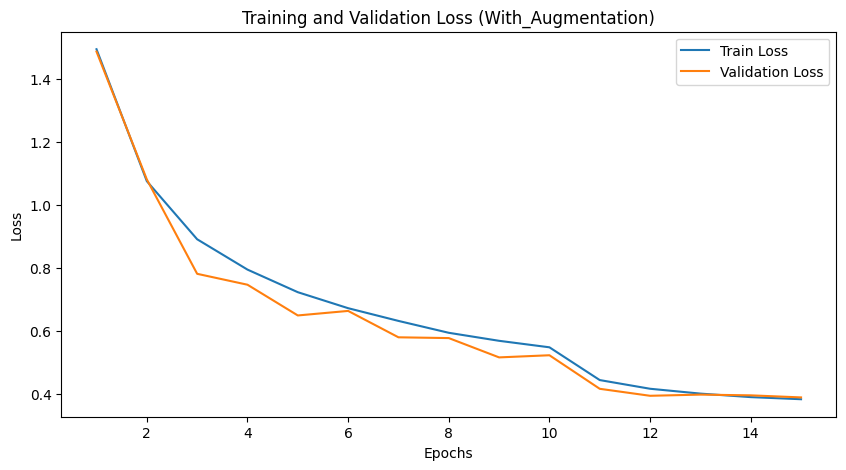

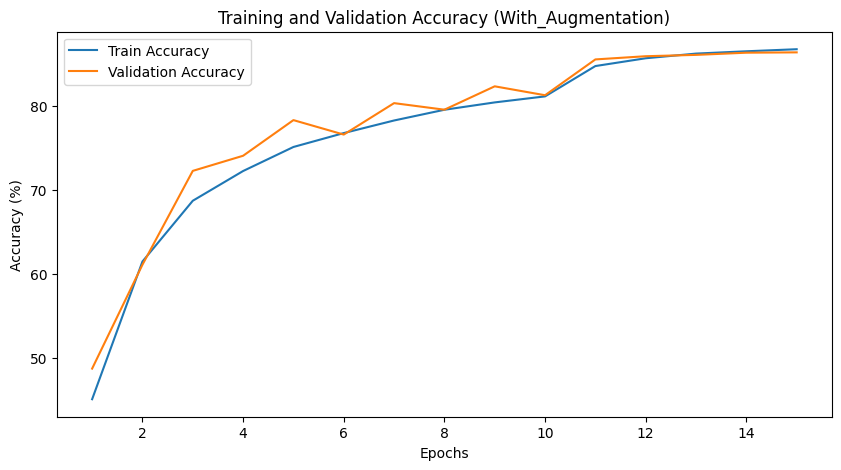

Classification Report:
              precision    recall  f1-score   support

    airplane       0.86      0.90      0.88      1000
  automobile       0.94      0.95      0.94      1000
        bird       0.85      0.81      0.83      1000
         cat       0.78      0.69      0.73      1000
        deer       0.85      0.85      0.85      1000
         dog       0.79      0.81      0.80      1000
        frog       0.88      0.92      0.90      1000
       horse       0.90      0.91      0.91      1000
        ship       0.92      0.94      0.93      1000
       truck       0.92      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:


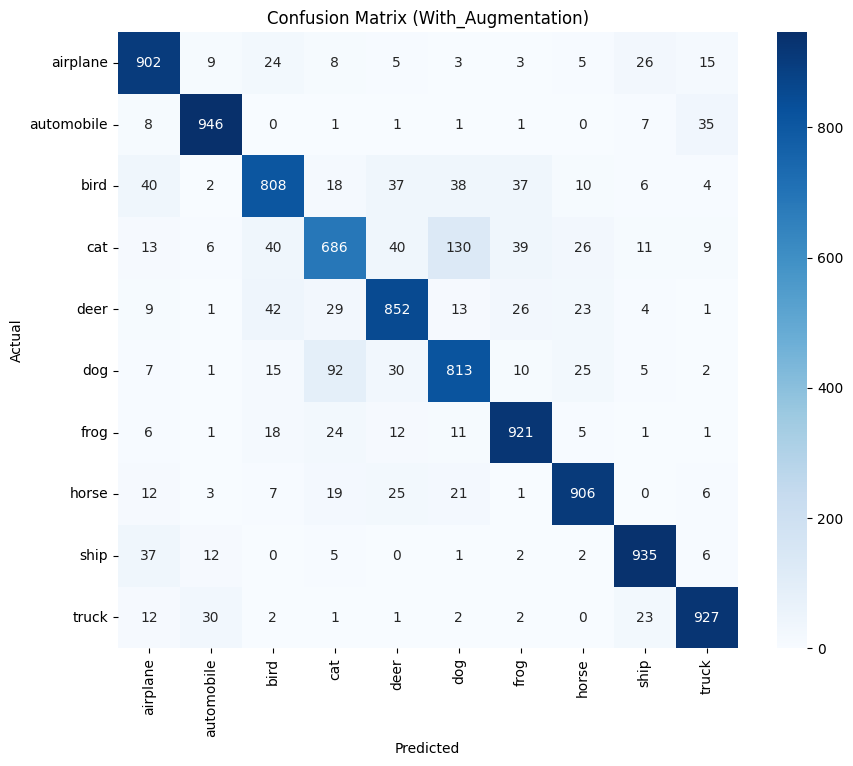

Top-1 Accuracy: 86.96%
Top-3 Accuracy: 97.88%


In [ ]:

train_and_evaluate(best_params_aug, transform_train_augmented, "With_Augmentation", train_idx_global, valid_idx_global)


Files already downloaded and verified
Files already downloaded and verified
[Without_Augmentation] Epoch [1/15], Train Loss: 1.2419, Train Acc: 54.84%, Valid Loss: 0.9767, Valid Acc: 65.64%, Time: 20.47s
[Without_Augmentation] Best model saved at epoch 1 with validation accuracy: 65.64%
[Without_Augmentation] Epoch [2/15], Train Loss: 0.8742, Train Acc: 69.22%, Valid Loss: 0.7851, Valid Acc: 72.92%, Time: 20.27s
[Without_Augmentation] Best model saved at epoch 2 with validation accuracy: 72.92%
[Without_Augmentation] Epoch [3/15], Train Loss: 0.7547, Train Acc: 73.60%, Valid Loss: 0.7098, Valid Acc: 74.08%, Time: 21.42s
[Without_Augmentation] Best model saved at epoch 3 with validation accuracy: 74.08%
[Without_Augmentation] Epoch [4/15], Train Loss: 0.6827, Train Acc: 75.97%, Valid Loss: 0.6126, Valid Acc: 78.98%, Time: 21.84s
[Without_Augmentation] Best model saved at epoch 4 with validation accuracy: 78.98%
[Without_Augmentation] Epoch [5/15], Train Loss: 0.6333, Train Acc: 77.76%, 

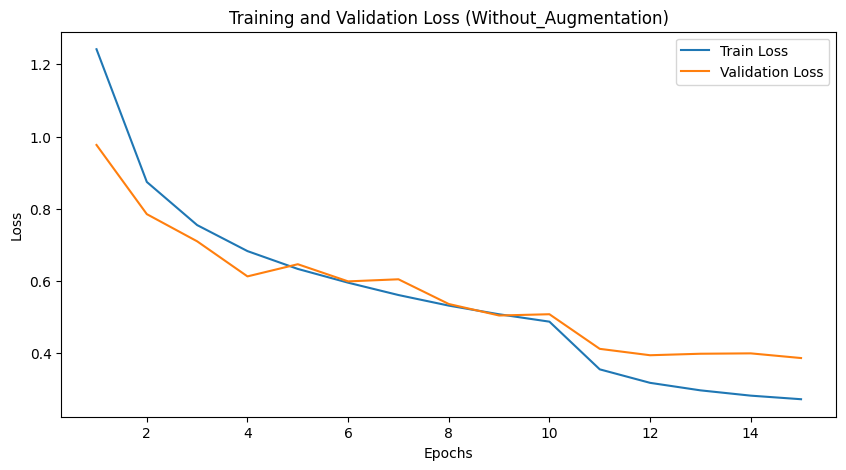

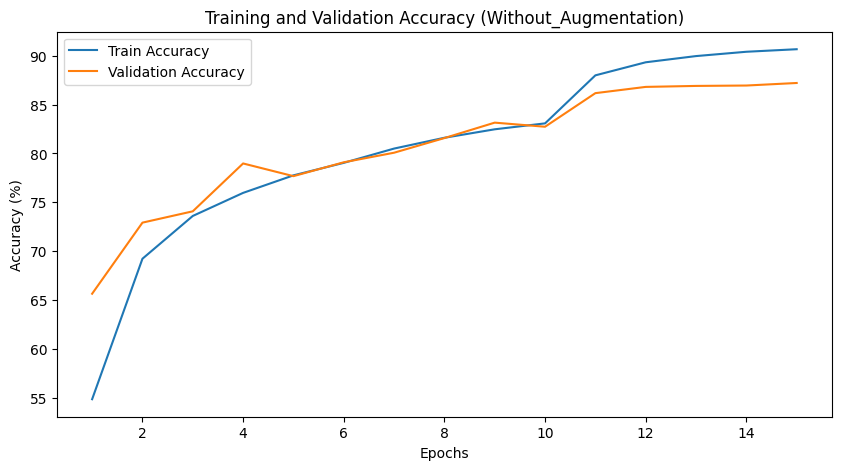

Classification Report:
              precision    recall  f1-score   support

    airplane       0.86      0.87      0.87      1000
  automobile       0.94      0.93      0.93      1000
        bird       0.83      0.79      0.81      1000
         cat       0.74      0.71      0.73      1000
        deer       0.84      0.87      0.85      1000
         dog       0.80      0.79      0.79      1000
        frog       0.87      0.90      0.89      1000
       horse       0.90      0.89      0.90      1000
        ship       0.91      0.92      0.92      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:


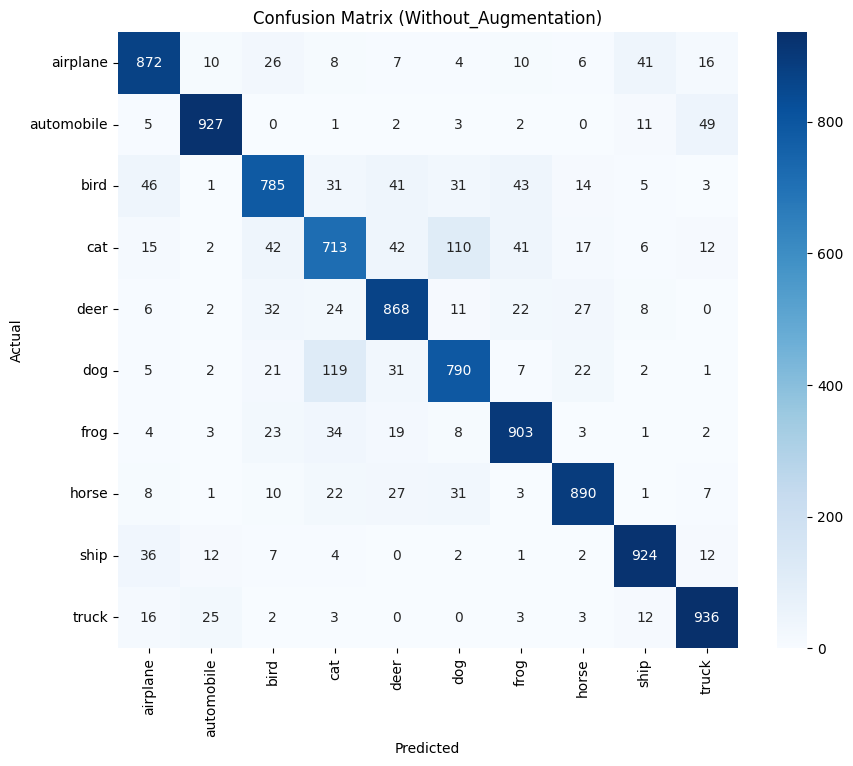

Top-1 Accuracy: 86.08%
Top-3 Accuracy: 97.63%


In [ ]:
train_and_evaluate(best_params_no_aug, transform_train_no_aug, "Without_Augmentation", train_idx_global, valid_idx_global)